In [1]:
import pathlib
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
# load dual imaging sessions
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GFlamp2')

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R20A02_R56H10_split_GFlamp2')
figfolder.mkdir(parents=True, exist_ok=True)

In [3]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [ ]:
from matplotlib.gridspec import GridSpec as GS
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def plot_sess_heatmaps_w_hist(ts, vmin=-.5, vmax=3, plot_times = np.arange(0,180,60),
                       ch1_heatmap = 'Greys', twindow=None,
                       bins = np.linspace(-np.pi, np.pi, num=17)):
    
    fig = plt.figure(figsize=[8,2])
    gs = GS(1,4, figure=fig, width_ratios=[6,1,.8, .2],wspace=.05,hspace=.8)
    heatmap_axs = [fig.add_subplot(gs[0]),]
    hist_axs = [fig.add_subplot(gs[1]), ]
    cbar_ax = [fig.add_subplot(gs[3]),]


    def get_time_ticks_inds(time, plot_times):
        inds = []
        for t in plot_times:
            inds.append(np.argmin(np.abs(time-t)))
        return inds
    
    def plot_row(ch, row, cmap, title, hatch=None):
        dff = ts.dff[ch,:,:]
        heading = ts.heading
        offset = ts.offset[ch,:]
        
        time = ts.time

        if twindow is not None:
            mask = (time>=twindow[0]) * (time<=twindow[1])
        else:
            mask = np.ones_like(time)>0

        dff= dff[:,mask]
        time = time[mask]
        heading = heading[mask]

        x = np.arange(dff.shape[1])
        heading_ = (heading + np.pi) / (2 * np.pi) * 15
        h = heatmap_axs[row].imshow(dff, aspect='auto', cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
        fig.colorbar(h, cax=cbar_ax[row])
        # heatmap_axs[row].scatter(x, heading_, color='orange', s=5)

        heatmap_axs[row].set_ylabel('ROIs')
        heatmap_axs[row].set_yticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
        heatmap_axs[row].yaxis.set_minor_locator(AutoMinorLocator())
        
        _plot_times = plot_times[plot_times<time.iloc[-1]]
        heatmap_axs[row].set_xticks(get_time_ticks_inds(time, _plot_times), labels=_plot_times)
        heatmap_axs[row].set_xlabel('Time (s)')
        
        heatmap_axs[row].set_title(title)

        
      
        centers = (bins[:-1] + bins[1:]) / 2
        hist, _ = np.histogram(offset, bins=bins)
        hist = hist / hist.sum()  # normalize
        if hatch is None:
            hist_axs[row].fill_betweenx(centers, 0, hist, color=cmap(.8), alpha=.5)
        else:
            hist_axs[row].fill_betweenx(centers, 0, hist, alpha=1, hatch=hatch,color='none', edgecolor=cmap(.8))

        # hist_axs[row].set_yticks([-np.pi,-3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
        #                          labels=[r'-$\pi$', '', '', '', r'0','', '', '', r'$\pi$'])
        hist_axs[row].set_yticks([-np.pi, 0,  np.pi], 
                                 labels=[r'-$\pi$',  r'0', r'$\pi$'])
        hist_axs[row].yaxis.set_minor_locator(AutoMinorLocator())
        hist_axs[row].set_ylim([np.pi, -np.pi])
        # hist_axs[row].set_xlim(left=0)
        hist_axs[row].grid(True, axis='y', linestyle='-', alpha=0.8,linewidth=2.5, which='major')
        ygridlines = hist_axs[row].get_ygridlines()
        ygridlines[1].set_color('orange')
        hist_axs[row].grid(True, axis='y', linestyle=':', alpha=0.5, linewidth=1.5, which='minor')
        hist_axs[row].set_ylabel('Offset')
        hist_axs[row].yaxis.tick_right()
        hist_axs[row].yaxis.set_label_position('right')
        hist_axs[row].set_xlabel('Prop.')
        offset_var = sp.stats.circvar(offset, low=-np.pi, high=np.pi)
        hist_axs[row].set_title(f"variance={offset_var:.2f}" )
    

    plot_row(0, 0, plt.cm.get_cmap('Greys'), 'GFlamp')
    
    
    return fig, (heatmap_axs, hist_axs, cbar_ax)


In [32]:
row = {'date': "26_11_2024",
       'fly': "fly1",
       'session': "closed_loop-000"}

/tmp/ipykernel_3083068/3746635170.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plot_row(0, 0, plt.cm.get_cmap('Greys'), 'GFlamp')


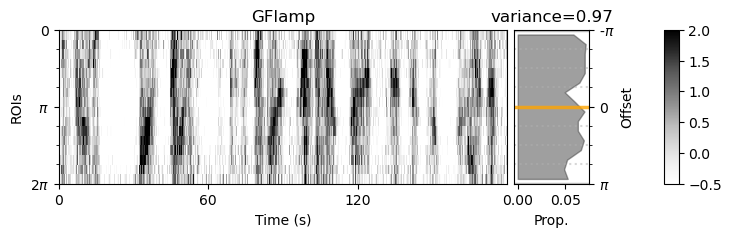

In [33]:
fig, ax = plot_sess_heatmaps_w_hist(nmp.session.GetTS(load_row(row), channels=(0,)), 
                                                  vmin=-.5, vmax=2, twindow=(0,180))